In [1]:
# THANK YOU, VIVEK, FOR THIS BEAUTIFUL CODE. 
# Original code by Vivek. Modified by Brandon 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from math import sin, cos, sqrt, atan2

In [3]:
%matplotlib inline

In [4]:
df = pd.read_csv("../../api/bird_unofficial_api/csv_output.csv")

In [5]:
# Preprocessing and adding date columns
days = ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun']
df['datetime'] = df['time_stamp'].apply(lambda x: datetime.fromtimestamp(x))
df['date_string'] = df['datetime'].apply(lambda x: x.strftime('%Y-%m-%d'))
df['week_day'] = df['datetime'].apply(lambda x: days[x.weekday()])

In [6]:
df.head()

,id,latitude,longitude,battery_level,captive,time_stamp,datetime,date_string,week_day
0,6787bc36-a67a-447c-923d-9803b0c70607,34.413387,-119.855317,93,False,1549498203,2019-02-06 16:10:03,2019-02-06,wed
1,ac581dd8-4bb7-41b8-a1af-848f0c82c9fa,34.413395,-119.855338,88,False,1549498203,2019-02-06 16:10:03,2019-02-06,wed
2,296a944c-b744-487c-91c8-94bc05d47c3c,34.413078,-119.854722,60,False,1549498203,2019-02-06 16:10:03,2019-02-06,wed
3,fd1859a9-8849-48e2-99ea-a76921a5a4c8,34.413685,-119.855472,88,False,1549498203,2019-02-06 16:10:03,2019-02-06,wed
4,c05fed3c-5da5-4fd9-8d63-be5127e920bc,34.412105,-119.855003,36,False,1549498203,2019-02-06 16:10:03,2019-02-06,wed


In [7]:
df['date_string'].unique()

array(['2019-02-06', '2019-02-03', '2019-02-05', '2019-02-04',
       '2019-02-01', '2019-01-27', '2019-01-25', '2019-01-28',
       '2019-01-24', '2019-01-26', '2019-02-02', '2019-01-29',
       '2019-01-30', '2019-01-31'], dtype=object)

In [8]:
def get_count_for_date(ds):
    day_df = df[df['date_string'] == ds]
    freq_df = day_df.groupby(pd.Grouper(key = 'datetime', freq='10min'))['id'].nunique()
    freq_df.plot(figsize=(10,5))

In [9]:
# Group data by date
date_df = df.groupby('date_string')['id'].nunique()

In [10]:
# Group data by week day
week_day_df = df.groupby('week_day')['id'].nunique()
week_day_df = week_day_df.reindex(index = days) #To have the same order as we define in days

In [11]:
# Euclidean distance calculation (only roughly accurate for 10 min interval polling)
# start and end are tuples of (lat, long)
def distance(start, end):
    R = 6373.0
    dlon = end[1] - start[1]
    dlat = end[0] - start[0]
    a = (sin(dlat/2))**2 + cos(start[0]) * cos(end[0]) * (sin(dlon/2))**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c
    return distance*1000 #km -> meters

In [43]:
# Return unique ids for given date
def day_ids(ds):
    day_df = df[df['date_string'] == ds]
    day_df = day_df.reset_index()
    unique_ids = pd.Series(day_df['id'].values).unique().tolist()
    print (pd.Series(day_df.id).nunique())
#     print (unique_ids)
    return unique_ids

In [44]:
# Returns df for specific Bird for a given day
def bird_data_by_day(ds, b_id):
    day_df = df[df['date_string'] == ds]
    day_df = day_df.reset_index()
    bird_df = day_df[day_df['id'] == b_id]
    return bird_df

In [45]:
def plot_bird_battery(ds, b_id):
    bird_df = bird_data_by_day(day, b_id)
    bird_df = bird_df.sort_values(by='datetime')
    bird_df = bird_df.reset_index(drop=True)
    bird_df.plot(x='datetime', y='battery_level', figsize=(10,5))

In [49]:
day = '2019-02-03'
unique_ids = day_ids(day)
bird_df = bird_data_by_day(day, unique_ids[1])
bird_df = bird_df.sort_values(by='datetime')
bird_df = bird_df.reset_index(drop=True)
bird_df['coordinates']= pd.Series(list(zip(bird_df.latitude, bird_df.longitude)))
dist_list = []
for i in range(len(bird_df.coordinates)):
    if i == 0:
        dist_list.append(0)
    else:
        dist_list.append(distance(bird_df.coordinates[i-1], bird_df.coordinates[i]))
bird_df['distance_traveled'] = pd.Series(dist_list)
# bird_df
# bird_df.plot(x='datetime', y='distance_traveled', figsize=(10,5))
# bird_df.plot(x='datetime', y='battery_level', figsize=(10,5))


185


# Visualizations

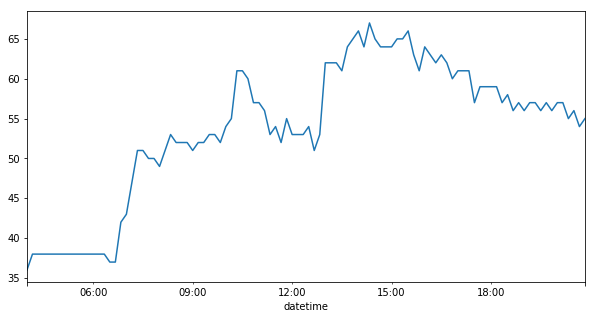

In [53]:
get_count_for_date('2019-02-04')

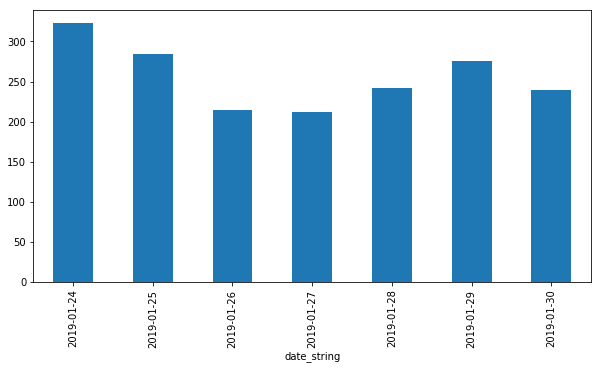

In [14]:
date_df.plot(kind='bar',figsize=(10,5))

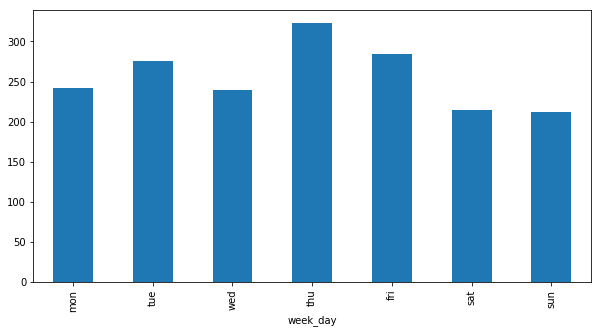

In [15]:
week_day_df.plot(kind='bar',figsize=(10,5))